In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import CubicSpline, lagrange
from scipy.optimize import curve_fit
from numpy.polynomial.polynomial import Polynomial
import random

## Make simple masks

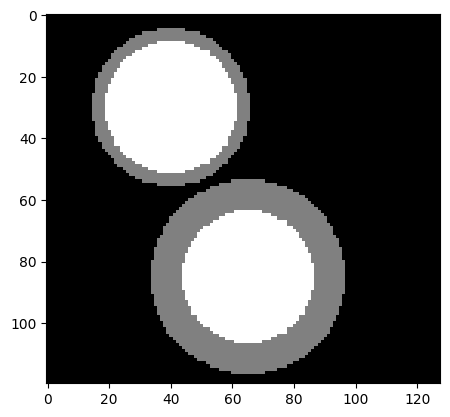

True

In [2]:
def simulate_bin_circle():
    image_hole = np.zeros((120, 128), dtype=np.float32)
    center_coordinates = (40, 30)
    center_coordinates2 = (65, 85)
    radius = 20

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    color = (191, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    
    # image_border = cv2.circle(image_hole, center_coordinates, radius+2, color_border, thickness_border)

    image_border = cv2.circle(image_hole, center_coordinates, radius+4, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates, radius+4, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates, radius, color_hole, thickness_hole)

    
    image_border = cv2.circle(image_hole, center_coordinates2, radius+10, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates2, radius+10, color_border, -1)
    image_hole = cv2.circle(image_border, center_coordinates2, radius, color_hole, 2)
    image_hole = cv2.circle(image_hole, center_coordinates2, radius, color_hole, thickness_hole)

    plt.imshow(image_hole, cmap='gray')
    plt.show()
    return image_border

img = simulate_bin_circle()
img_large = img

circle2 = img_large.copy()

cv2.imwrite('input_crop_mask.png', np.clip(circle2, 0, 255))

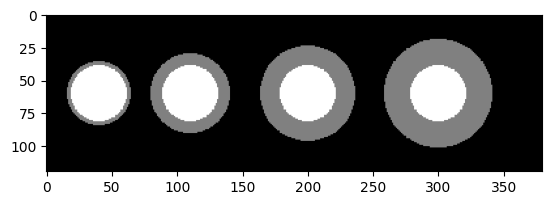

True

In [3]:
def simulate_circles():
    image_hole = np.zeros((120, 380), dtype=np.float32)
    center_coordinates1 = (40, 60)
    center_coordinates2 = (110, 60)
    center_coordinates3 = (200, 60)
    center_coordinates4 = (300, 60)

    radius = 20

    color_border = (128, 0, 0)
    color_hole = (255, 0, 0)
    
    thickness_border = -1
    thickness_hole = -1

    # border 3
    image_border = cv2.circle(image_hole, center_coordinates1, radius+3, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates1, radius+3, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates1, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates1, radius, color_hole, thickness_hole)

    # border 9
    image_border = cv2.circle(image_hole, center_coordinates2, radius+9, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates2, radius+9, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates2, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates2, radius, color_hole, thickness_hole)

    # border 15
    image_border = cv2.circle(image_hole, center_coordinates3, radius+15, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates3, radius+15, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates3, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates3, radius, color_hole, thickness_hole)

    # border 20
    image_border = cv2.circle(image_hole, center_coordinates4, radius+20, color_border, 2)
    image_border = cv2.circle(image_border, center_coordinates4, radius+20, color_border, thickness_border)
    image_hole = cv2.circle(image_border, center_coordinates4, radius, color_hole,2)
    image_hole = cv2.circle(image_hole, center_coordinates4, radius, color_hole, thickness_hole)

    # print(np.unique(image_border))
    plt.imshow(image_hole, cmap='gray')
    plt.show()

    # cv2.imwrite('./data/test_img_two.png', image_border)
    return image_border

img_circles = simulate_circles()
cv2.imwrite('difr_circles.png', np.clip(img_circles, 0, 255))

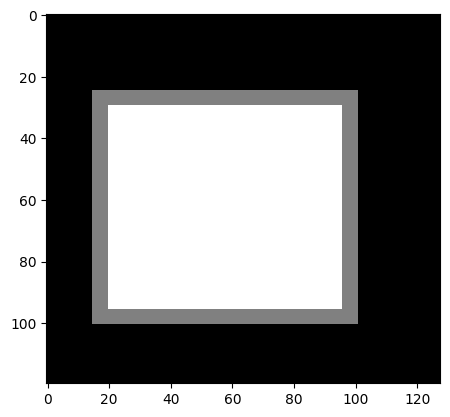

True

In [56]:
def simulate_square():
    top_vert_bord = (15,25)
    bot_vert_bord = (100,100)

    top_vert_hole = (20,30)
    bot_vert_hole = (95,95)
    color_bord = 128
    color_hole = 255
    radius = 15
    img = np.zeros((120, 128), dtype=np.float32)
    cv2.rectangle(img,top_vert_bord,bot_vert_bord,color_bord,-1)
    cv2.rectangle(img,top_vert_hole,bot_vert_hole,color_hole,-1)


    plt.imshow(img, cmap='gray')
    plt.show()

    return img


img_square = simulate_square()
cv2.imwrite('square.png', np.clip(img_square, 0, 255))


## Смотрим на срезы сразу после маски

Text(0.5, 1.0, 'Сразу после маски горизонтальный срез')

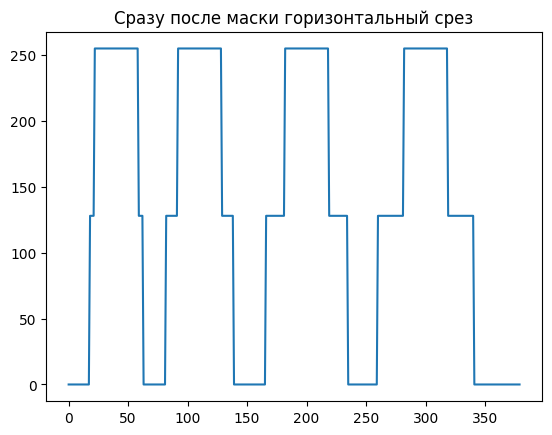

In [4]:
plt.plot(np.arange(0, img_circles.shape[1]), img_circles[50,:])
plt.title('Сразу после маски горизонтальный срез')

Text(0.5, 1.0, 'Сразу после маски вертикальный срез')

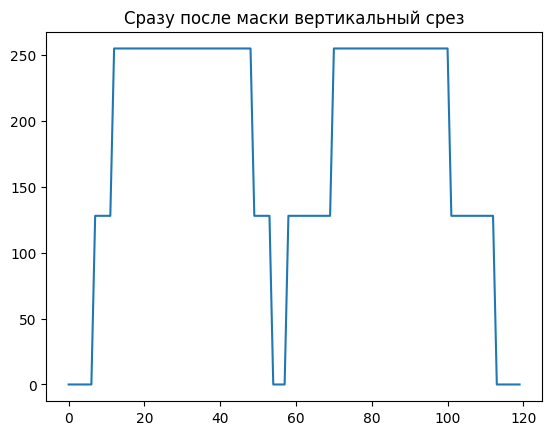

In [5]:
plt.plot(np.arange(0, circle2.shape[0]), circle2[:,50])
plt.title('Сразу после маски вертикальный срез')

## Считаем ширину границ

In [6]:
def get_edges_width(img):
    bord_mask = img == 128
    bord_mask = bord_mask.astype(np.uint8)
    # bord_mask = bord_mask.astype(np.uint8)

    hole_mask = cv2.inRange(img, 255,255)
    rows, cols = img.shape
    dist_final = np.zeros_like(img)
    dist_y = np.zeros_like(img, dtype=np.float32)
    for col in range(0, cols):
        col_mask = bord_mask[:, col]
        nonzero_ind = np.nonzero(col_mask)[0]
        start_ind = np.where(np.diff(col_mask == 1))[0] + 1
        segments = np.split(col_mask, start_ind)
        tmp = 0 
        
        for segm in segments:
            dist_y[:, col][tmp:tmp + len(segm)] = (len(segm))
            tmp = tmp + len(segm)
    dist_x = np.zeros_like(img, dtype=np.float32)
    for row in range(0, rows):
        row_mask = bord_mask[row,:]
        nonzero_ind = np.nonzero(row_mask)[0]
        start_ind = np.where(np.diff(row_mask == 1))[0] + 1
        segments = np.split(row_mask, start_ind)
        tmp = 0 
        
        for segm in segments:
            dist_x[row, :][tmp:tmp + len(segm)] = (len(segm))
            tmp = tmp + len(segm)
    y = dist_y.copy()
    x = dist_x.copy()

    dist = np.zeros_like(dist_x,dtype=np.float32)
    dist[img == 128] = np.minimum(dist_x[img == 128], dist_y[img == 128])
    dist[img != 0] = np.minimum(dist_x[img != 0], dist_y[img != 0])

    # ___added____
    bord_mask = cv2.inRange(img, 128, 128)
    bord_mask[bord_mask == 255] = 128
    hole_mask = cv2.inRange(img, 255,255)
    hole_mask = hole_mask.astype(np.uint8)
    bord_mask = bord_mask.astype(np.uint8)
    for col in range(0, cols):
        # if col == 41:
        col_mask_bord = bord_mask[:,col]
        col_mask_hole = hole_mask[:,col]

        nonzero_ind_bord = np.nonzero(col_mask_bord)[0]
        nonzero_ind_hole = np.nonzero(col_mask_hole)[0]

        start_ind_bord = np.where(np.diff(col_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(col_mask_hole == 255))[0] + 1
        gray_segments = []
        segments= []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        work_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
        for segm in work_segments:
            # print(segm)
            dist_final[segm[0]:segm[1], col] = y[segm[0]:segm[1], col]


    for row in range(0, rows):
        # if row == 95:
        row_mask_bord = bord_mask[row,:]
        row_mask_hole = hole_mask[row,:]

        nonzero_ind_bord = np.nonzero(row_mask_bord)[0]
        nonzero_ind_hole = np.nonzero(row_mask_hole)[0]

        start_ind_bord = np.where(np.diff(row_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(row_mask_hole == 255))[0] + 1
        # print('start ind hole', start_ind_hole)
        gray_segments = []
        # white_segments_cols = []
        segments= []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
        
        for segm in work_segments:
            dist_final[row, segm[0]:segm[1]] = x[row, segm[0]:segm[1]]

    return dist

In [7]:
img_circles_edges_width = get_edges_width(img_circles)

строить кружок до пересечения с внутренним контуром

проверять пересечение двух контуров, запоминать точку ???, затем брать радиус на один меньше как ширину границы

In [6]:
circle2 = img_circles.copy()

# img_square = cv2.imread('square.png', 0)
# circle2 = img_square.copy()

In [10]:
def brezenhem(x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    steep = dy > dx
    # steep = dx > dy

    
    if steep:
        x0, y0 = y0, x0
        x1, y1 = y1, x1
    
    swapped = False
    if x0 > x1:
        x0, x1 = x1, x0
        y0, y1 = y1, y0
        swapped = True

    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    error = np.round((dx / 2),0).astype(np.int32)
    ystep = 1 if y0 < y1 else -1

    y = y0
    points = []
    for x in range(x0, x1 + 1):
        if steep:
            points.append((y, x))
            # points.append((x, y))

        else:
            points.append((x, y))
            # points.append((y, x))

        error -= dy
        if error < 0:
            y += ystep
            error += dx

    if swapped:
        points.reverse()

    return points


def draw_line(z, points, color):
    for x, y in points:
        z[y][x] = color
    return z

In [9]:
# mask_bord = cv2.inRange(circle2, 128,128)
# cont_circle2, hier_circle2 = cv2.findContours(mask_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# ext = []
# int = []
# width_img = circle2.copy()

# fig, ax = plt.subplots(1,1,figsize=(10, 10))
# ax.imshow(circle2)
# for i in range(len(cont_circle2)):
#     mask_cont = np.zeros_like(circle2)
#     # fig, ax = plt.subplots(1,1,figsize=(10, 10))
#     # ax.imshow(circle2)
#     # mask_cont = circle2.copy()

#     if hier_circle2[0][i][3] == -1:
#         mask_cont = cv2.drawContours(mask_cont, [cont_circle2[i]], 0, 200, 0)
#         nonzero = np.argwhere(mask_cont > 0)
#         nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
#         ext.append(nonzero)

#     else:
#         mask_cont = cv2.drawContours(mask_cont, [cont_circle2[i]], 0, 1, 0)
#         nonzero = np.argwhere(mask_cont > 0)
#         nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
#         int.append(nonzero)

# for cont_ext, cont_int in zip(ext, int):
#     mask = np.zeros_like(circle2)
#     # mask = cv2.drawContours(mask, [cont_int], 0, 2, 0)
#     mask = cv2.fillPoly(mask, [cont_int], 2)

#     # тест отображения маски
#     # fig, ax = plt.subplots(1,2,figsize=(10, 10))
#     # ax[0].imshow(mask)
#     # ax[0].set_title('mask')
#     # ax[1].imshow(circle2)

#     img = np.zeros_like(circle2)

#     # тест отображения контуров
#     # fig, ax = plt.subplots(1,1,figsize=(10, 10))
#     # ax.imshow(img)
#     # ax.scatter(cont_ext[:,0], cont_ext[:,1], color='orange')
#     # ax.scatter(cont_int[:,0], cont_int[:,1], color='blue')

#     # for point_ext in cont_ext:
#     for point_int in cont_int:

#         # ax.scatter(point_ext[0], point_ext[1], color='red', s=2)
#         # start_point = (point_ext[0], point_ext[1])
#         start_point = (point_int[0], point_int[1])

#         radius = 1
#         flag = True

#         # тест отображения контуров, начальной точки и рисующегося круга
#         # fig, ax = plt.subplots(1,1,figsize=(10, 10))
#         # ax.imshow(circle2)

#         # ax.scatter(cont_ext[:,0], cont_ext[:,1], color='orange', s=3, alpha=0.5)
#         # ax.scatter(cont_int[:,0], cont_int[:,1], color='blue', s=3, alpha=0.5)
#         # ax.scatter(point_ext[0], point_ext[1], color='red', s=2, alpha=0.5)
#         # ax.imshow(mask)

#         # intersect = []
#         while flag:
        
#             mask = np.zeros_like(circle2)
#             mask = cv2.circle(mask, start_point, radius, 255, -1)
#             mask = cv2.inRange(mask, 255,255)
#             cont_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#             mask_cont = np.zeros_like(circle2)

#             cv2.drawContours(mask_cont, cont_mask,  -1, 1, 0)
#             nonzero = np.argwhere(mask_cont > 0)
#             nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])

#             # plt.imshow(mask_cont)
#             # plt.scatter(nonzero[:,0], nonzero[:,1], color='green', s=1)
#             # print(type(nonzero), type(cont_int))
#             # print(len(nonzero))
#             # intersect = np.array([x for x in set(tuple(x) for x in nonzero) & set(tuple(x) for x in cont_int)])
#             intersect = np.array([x for x in set(tuple(x) for x in nonzero) & set(tuple(x) for x in cont_ext)])

#             if len(intersect) != 0:
#                 flag=False

#             else:
#                 radius += 1

#         # print(intersect)
#         dist = float('inf')
#         for dot in intersect:
#             dist_ = np.sqrt((start_point[0] - dot[0])**2 + (start_point[1] - dot[1])**2) + 1
#             if dist_ <= dist:
#                 dist = dist_
#                 nearest_point = dot

#         points = brezenhem(start_point[0], start_point[1], nearest_point[0], nearest_point[1])
#         width_img = draw_line(width_img, points, 50)
#         # print('наклон: ', ((start_point[1] - dot[1])/(start_point[0] - dot[0])))

#         # print(np.round(dist_,0).astype(np.int32))

#         # print(start_point, nearest_point)
#         ax.plot([start_point[0], nearest_point[0]], [start_point[1], nearest_point[1]], color='green')


        
#         # ax.imshow(np.clip(intersect,0,1))

#             # print(nonzero)
#             # mask = cv2.drawContours(mask, [cont_int], 0, 2, 0)
#             # if len(nonzero) != 0:
#             #     flag = False
#                 # for i in nonzero:
#                 #     # print(mask[i[0], i[1]])
#                 #     if mask[i[0], i[1]] == 2.0:
#                 #         ax.scatter(i[0], i[1], color='green', s=2)
#                     # flag=False
#                     # print('hi')
#                     # point = (i[0], i[1])
#                     # break
#             # flag = False
#             # else:
#             #     radius += 1

#         ax.scatter(cont_ext[:,0], cont_ext[:,1], color='orange', s=1, alpha=0.5)
#         ax.scatter(cont_int[:,0], cont_int[:,1], color='blue', s=1, alpha=0.5)
#         # ax.scatter(point_ext[0], point_ext[1], color='red', s=0.5, alpha=0.5)




#         # if circle2[start_point[0]+1, start_point[1]]==128:
#         #     ax.scatter(start_point[0]+1, start_point[1], color='green', s=2)
#         # elif circle2[start_point[0]-1, start_point[1]]==128:
#         #     ax.scatter(start_point[0]-1, start_point[1], color='purple', s=2)
#         # elif circle2[start_point[0], start_point[1]+1]==128:
#         #     ax.scatter(start_point[0], start_point[1]+1, color='hotpink', s=2)
#         # elif circle2[start_point[0], start_point[1]-1]==128:
#         #     ax.scatter(start_point[0], start_point[1]-1, color='pink', s=2)   

#         # print(np.rad2deg(np.arctan2((start_point[1] - start_point[1]), (start_point[0]-1-start_point[0]))))
#             # print()


#         # x = []
#         # y = []
#         # for theta in range(0, 360):  # Проходимся по всем углам от 0 до 360 градусов
#         #     x.append(np.round((start_point[0] + radius * np.cos(np.radians(theta))), 0).astype(np.int32))
#         #     y.append(np.round((start_point[1] + radius * np.sin(np.radians(theta))), 0).astype(np.int32))
#         # print(x, y)  
#         # ax.scatter(x, y, color='hotpink', s=2)


#         # break

#     # break


In [10]:
circle2 = cv2.imread('/home/sasha/WSLProjects/sem_simulator/difr_circles.png', 0)

In [11]:
mask_bord = cv2.inRange(circle2, 128,128)
cont_circle2, hier_circle2 = cv2.findContours(mask_bord, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
ext = []
int = []


for i in range(len(cont_circle2)):
    mask_cont = np.zeros_like(circle2)

    if hier_circle2[0][i][3] == -1:
        mask_cont = cv2.drawContours(mask_cont, [cont_circle2[i]], 0, 200, 0)
        nonzero = np.argwhere(mask_cont > 0)
        nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
        ext.append(nonzero)

    else:
        mask_cont = cv2.drawContours(mask_cont, [cont_circle2[i]], 0, 1, 0)
        nonzero = np.argwhere(mask_cont > 0)
        nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
        int.append(nonzero)

In [12]:
# if img[row, segm[1]+1] < img[row, segm[0]-1]:
#                     k = delta - (segm[1] - i)
#                 else:
#                     k = delta - (np.abs(segm[0] - i))
#                 k_val = k * (color_back - color_hole) // delta + color_hole
#                 color_final[row, i] = k_val

Text(0.5, 1.0, 'height')

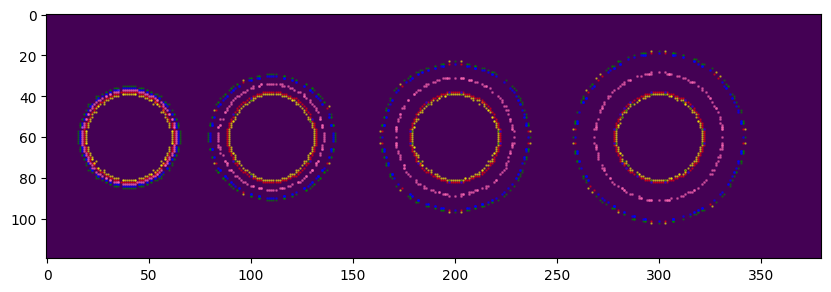

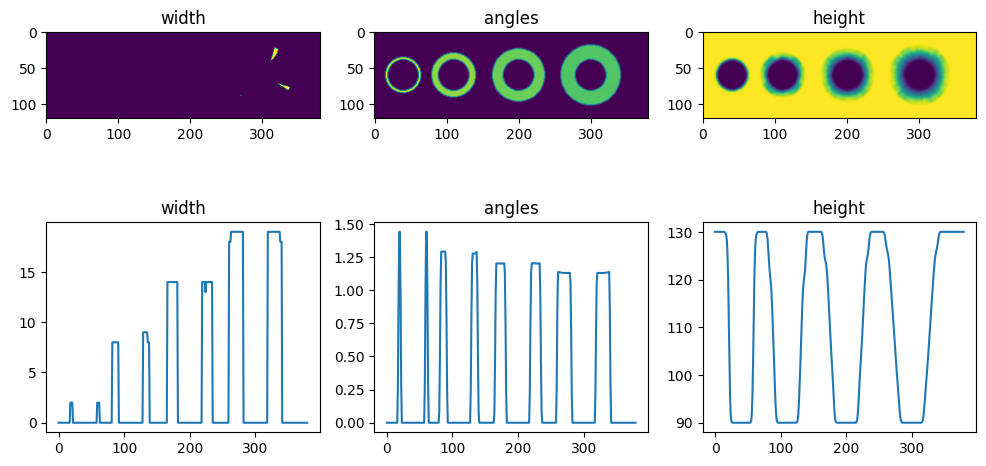

In [300]:
from skimage.draw import line

fig, ax = plt.subplots(1,1,figsize=(10, 10))
cp = np.zeros_like(circle2)
ax.imshow(cp)
# modes = []
color_back = 130
color_hole = 90

width_img = circle2.copy()
angles_img = circle2.copy()
# new_angles = circle2.copy()
new_angles = np.zeros_like(circle2, dtype=np.float32)
height_img = circle2.copy()
height_img[circle2 == 0] = color_back
height_img[circle2 == 255] = color_hole




width_img[circle2 == 0] = 0
width_img[circle2 == 255] = 0
# new_angles[circle2 == 255] = 0
flag = True

def parabola(x, a, b, c):
    return a*x**2 + b*x + c


def draw_gradient_line(img, start_point, end_point, points, colors, thickness=4, flag=None):
    start = start_point
    if flag is None:
        for i in range(1, len(points) - 1):
            # if img[start[1], start[0]] == 0 or img[start[1], start[0]] == 255 or img[start[1], start[0]]==128:
            cv2.line(img, start, points[i+1], colors[i], thickness)
            start = points[i]
    elif flag == 'ext':
        for i in range(1, len(points) - 1):
            if img[start[1], start[0]] == 0 or img[start[1], start[0]] == 255 or img[start[1], start[0]]==128:
                print(start)
                cv2.line(img, start, points[i+1], colors[i], thickness)
                start = points[i]



def compute_previous_pixel(first_pixel, last_pixel, distance=1):
    x1, y1 = first_pixel
    x2, y2 = last_pixel

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = -distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

def compute_next_pixel(first_point, last_point, distance=1):
    x1, y1 = first_point
    x2, y2 = last_point

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = 1 + distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

    # return img

for cont_ext, cont_int in zip(ext, int):
    # print(i)
    mask = np.zeros_like(circle2)
    mask = cv2.fillPoly(mask, [cont_int], 2)
    img = np.zeros_like(circle2)
    # for point_ext in cont_ext:
    modes = ['internal', 'external']
    # modes = ['external']

    for mode in modes:
        # print(mode)
        if mode == 'external':
            cont = cont_ext.copy()
            # other_cont = cont_int
        else:
            cont = cont_int.copy()
        for point in cont:
            if mode == 'external':
                if width_img[point[1], point[0]] != 128:
                    continue
            
            radius = 1
            flag = True
            while flag:
                mask = np.zeros_like(circle2)
                mask = cv2.circle(mask, point, radius, 255, -1)
                mask = cv2.inRange(mask, 255,255)
                cont_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                mask_cont = np.zeros_like(circle2)
                cv2.drawContours(mask_cont, cont_mask,  -1, 1, 0)
                nonzero = np.argwhere(mask_cont > 0)
                nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
                if mode == 'internal':
                    intersect = np.array([x for x in set(tuple(x) for x in nonzero) & set(tuple(x) for x in cont_ext)])
                else:
                    intersect = np.array([x for x in set(tuple(x) for x in nonzero) & set(tuple(x) for x in cont_int)])
                    # intersect
                if len(intersect) != 0:
                    flag=False
                else:
                    radius += 1

            dist = float('inf')
            for dot in intersect:
                dist_ = np.sqrt((point[0] - dot[0])**2 + (point[1] - dot[1])**2)
                # if mode == 'external':
                #     dist_ -= 1
                # if dist_ == 0:
                #     # print('zero')
                #     dist_ = 1
                if dist_ < dist:
                    dist = np.round(dist_, 0)
                    nearest_point = dot
            # if point[0] == nearest_point[0]:
            #     dist = np.round(np.abs(point[1] - nearest_point[1]),0).astype(np.int32)
            #     print(dist)

            # if point[1] == nearest_point[1]:
            #     dist = np.round(np.abs(point[0] - nearest_point[0]),0).astype(np.int32)
            #     print(dist)
            # if point[0] == nearest_point[0]:
            #     print('vert')
            #     k = np.arange(1, dist+1)
            #     if mode == 'external':
            #         height_vals = [(((dist+1 - k_) * ((color_back - color_hole) / dist)) + color_hole) for k_ in k]
            #     elif mode == 'internal':
            #         height_vals = [((k_ * ((color_back - color_hole) / dist)) + color_hole) for k_ in k]

            #     draw_gradient_line(height_img, point, nearest_point, discrete_line, height_vals)
                    
            # if point[1] == nearest_point[1]:
            #     print('hor')
            #     # print('vert')
            #     k = np.arange(1, dist+1)
            #     if mode == 'external':
            #         height_vals = [(((dist+1 - k_) * ((color_back - color_hole) / dist)) + color_hole) for k_ in k]
            #     elif mode == 'internal':
            #         height_vals = [((k_ * ((color_back - color_hole) / dist)) + color_hole) for k_ in k]

            #     draw_gradient_line(height_img, point, nearest_point, discrete_line, height_vals)
            discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            discrete_line_x = np.array(list(zip(*discrete_line))[0])
            
            mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
            prev = [compute_previous_pixel(point, nearest_point)]
            next = [compute_next_pixel(point, nearest_point)]


            angle = np.arctan(700 / (dist * 12))
            ax.scatter(point[0], point[1], color='red', s=0.5, alpha=0.5)
            ax.scatter(prev[0][0], prev[0][1], color='yellow', s=0.5, alpha=0.5)
            ax.scatter(next[0][0], next[0][1], color='green', s=0.5, alpha=0.5)
            ax.scatter(nearest_point[0], nearest_point[1], color='blue', s=1, alpha=0.5)
            ax.scatter(mid_point[0], mid_point[1], color='hotpink', s=1, alpha=0.5)



            points = brezenhem(point[0], point[1], nearest_point[0], nearest_point[1])

            # print(points, discrete_line)
            # if mode == 'internal':
            # width_img = draw_line(width_img, points, dist)
            # print(type(dist))
            cv2.line(width_img, point, nearest_point, dist, 4)
            if dist >= 3:
                val = angle*0.9
            else:
                val = angle
            cv2.line(angles_img, point, nearest_point, val, 4)

            # k = np.arange(1, dist+1, dtype=np.int32)
            # print(k)
            # if mode == 'external':
            #     # height_vals = [(((dist - k_) * ((color_back - color_hole) / dist)) + color_hole) for k_ in range(1, (dist+1).astype(np.int32))]
            #     # print(dist)
            #     height_vals = [(color_back - (k_ * ((color_back - color_hole) / dist))) for k_ in range(1, (dist+1).astype(np.int32))]
            #     # height_vals = [(color_back - (k_ * ((color_back - color_hole) / dist))) for k_ in range(1, (dist).astype(np.int32))]
                
            #     print('ext', height_vals)
            #     n = len(discrete_line)//2
            # #     # draw_gradient_line(height_img, point, nearest_point, discrete_line[:-1], height_vals, thickness=4, flag='ext')
            #     draw_gradient_line(height_img, point, nearest_point, discrete_line[1:n], height_vals[1:], thickness=1, flag='ext')
            # #     draw_gradient_line(height_img, point, nearest_point, discrete_line[1:-1], height_vals[1:], thickness=4)



            if mode == 'internal':
                # k = np.arange(1, dist+1, dtype=np.int32)
                # print((dist+1).astype(np.int32))
                height_vals = [((k_ * ((color_back - color_hole) / dist)) + color_hole) for k_ in range(1, (dist).astype(np.int32))]
                # height_vals = [((k_ * ((color_back - color_hole) / dist)) + color_hole) for k_ in range(1, (dist).astype(np.int32))]

                # print('int', height_vals)

                draw_gradient_line(height_img, point, nearest_point, discrete_line[:-1], height_vals, thickness=4)
                # draw_gradient_line(height_img, point, nearest_point, discrete_line[1:], height_vals, thickness=4)


            # height_vals = [((k_ * ((color_back - color_hole) / dist)) + color_hole) for k_ in range(1, (dist+1).astype(np.int32))]

            # draw_gradient_line(height_img, point, nearest_point, discrete_line, height_vals)

mask = circle2 != 128 

width_img[mask] = 0
angles_img[mask] = 0
height_img[circle2 == 0] = color_back
height_img[circle2 == 255] = color_hole
height_img = cv2.GaussianBlur(height_img, (7, 7), 0)
angles_img = cv2.GaussianBlur(angles_img, (3, 3), 0)



y = 40

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(width_img==20)
ax[0,0].set_title(f'width')


ax[0,1].imshow(angles_img)
ax[0,1].set_title(f'angles')

ax[0,2].imshow(height_img)
ax[0,2].set_title(f'height')


ax[1,0].plot(width_img[50, :])
ax[1,0].set_title(f'width')


ax[1,1].plot(angles_img[50, :])
ax[1,1].set_title(f'angles')

ax[1,2].plot(height_img[50, :])
ax[1,2].set_title(f'height')



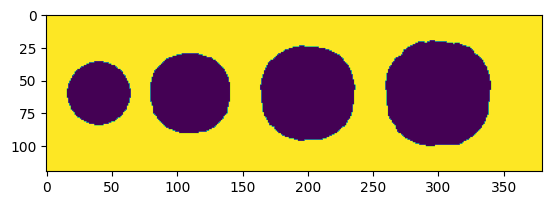

In [308]:
plt.imshow(height_img>128)

In [275]:
cv2.imwrite('./color_map2.png', height_img)

True

## interpolate angles

/home/sasha/.local/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


[0.0000000e+00 3.6342745e-04 3.7857026e-04 ... 1.1686062e+00 1.1719189e+00
 1.1719190e+00]


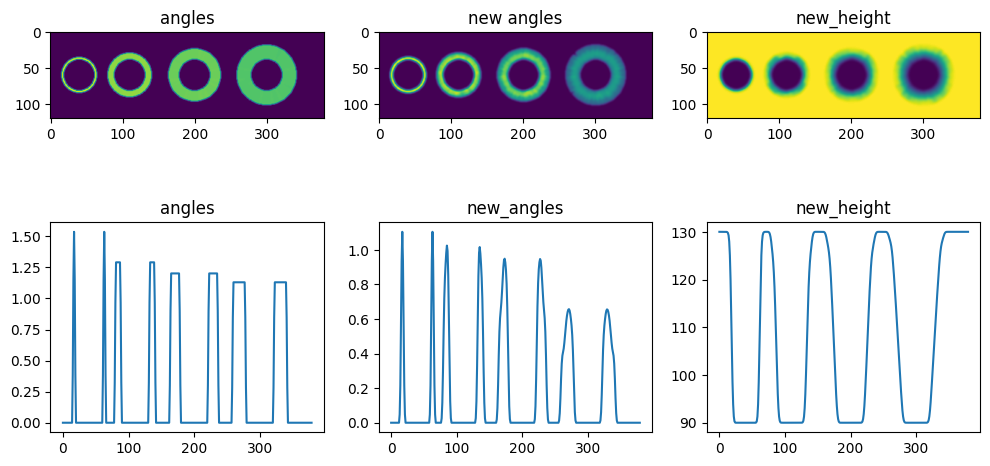

In [309]:
color_back = 125
color_hole = 90

new_angles = np.zeros_like(circle2, dtype=np.float32)
new_height = np.zeros_like(circle2, dtype=np.float32)


flag = True

def parabola(x, a, b, c):
    return a*x**2 + b*x + c


def draw_gradient_line(img, start_point, end_point, points, colors, thickness=4):
    start = start_point
    for i in range(1, len(points) - 1):

        cv2.line(img, start, points[i+1], colors[i], thickness)
        start = points[i]


def compute_previous_pixel(first_pixel, last_pixel, distance=1):
    x1, y1 = first_pixel
    x2, y2 = last_pixel

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = -distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)


def compute_next_pixel(first_point, last_point, distance=1):
    x1, y1 = first_point
    x2, y2 = last_point

    length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    t = 1 + distance / length
    x_t = np.round((x1 + t * (x2 - x1)), 0).astype(np.int32)
    y_t = np.round((y1 + t * (y2 - y1)), 0).astype(np.int32)

    return (x_t, y_t)

    # return img

for cont_ext, cont_int in zip(ext, int):
    # print(i)
    mask = np.zeros_like(circle2)
    mask = cv2.fillPoly(mask, [cont_int], 2)
    img = np.zeros_like(circle2)
    # for point_ext in cont_ext:
    modes = ['internal', 'external']
    # modes = ['external']

    for mode in modes:
        # print(mode)
        if mode == 'external':
            cont = cont_ext.copy()
            # other_cont = cont_int
        else:
            cont = cont_int.copy()
        for point in cont:
            if mode == 'external':
                if width_img[point[1], point[0]] != 128:
                    continue
            
            radius = 1
            flag = True
            while flag:
                mask = np.zeros_like(circle2)
                mask = cv2.circle(mask, point, radius, 255, -1)
                mask = cv2.inRange(mask, 255,255)
                cont_mask, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
                mask_cont = np.zeros_like(circle2)
                cv2.drawContours(mask_cont, cont_mask,  -1, 1, 0)
                nonzero = np.argwhere(mask_cont > 0)
                nonzero = np.array([list(reversed(nonz)) for nonz in nonzero])
                if mode == 'internal':
                    intersect = np.array([x for x in set(tuple(x) for x in nonzero) & set(tuple(x) for x in cont_ext)])
                else:
                    intersect = np.array([x for x in set(tuple(x) for x in nonzero) & set(tuple(x) for x in cont_int)])
                    # intersect
                if len(intersect) != 0:
                    flag=False
                else:
                    radius += 1

            dist = float('inf')
            for dot in intersect:
                dist_ = np.sqrt((point[0] - dot[0])**2 + (point[1] - dot[1])**2)
                # if mode == 'internal':
                #     dist_ += 1
                # if dist_ == 0:
                #     # print('zero')
                #     dist_ = 1
                if dist_ < dist:
                    dist = np.round(dist_, 0)
                    nearest_point = dot

            discrete_line = list(zip(*line(*point, *nearest_point))) # find all pixels from the line
            discrete_line_x = np.array(list(zip(*discrete_line))[0])
            # if flag:
            # print('nearest_point', nearest_point)
            # extrapolated_point = (1 + 1) * point - 1 * nearest_point
            # extrapolated_point = nearest_point + 1

            # print('next ', extrapolated_point)
            # flag = False
            # mid_point = 
            # print(point, nearest_point)
            mid_point = [(point[0] + nearest_point[0])//2, (point[1] + nearest_point[1])//2]
            prev = [compute_previous_pixel(point, nearest_point)]
            next = [compute_next_pixel(point, nearest_point)]
            angle = np.arctan(700 / (dist * 12))
            # # angles interpolation - work
            if dist > 4:
                k = dist/10
                # if k > 1:
                # print(dist, k, angle)
                if k < 1:
                    val = angle*k
                else:
                    val = angle/k
                y_mean = val
                y_0 = val/2
                y_n = val/2
                x_plot = np.arange(0, len(discrete_line))
                coefs = curve_fit(parabola, [x_plot[0], x_plot[len(x_plot)//2], x_plot[-1]], [y_0, y_mean, y_n])
                a,b,c = coefs[0]
                y_parabola = parabola(x_plot, a, b, c)
                heights = y_parabola
                draw_gradient_line(new_angles, point, nearest_point, discrete_line, np.abs(y_parabola), thickness=5)
            else:
                val = angle
                cv2.line(new_angles, point, nearest_point, val, 4)

            # k = np.arange(1, dist+1)
            # if mode == 'external':
            #     print('ext')
            # #   print(k_) for k_ in k
            #     for k_ in k:
            #         print(y_parabola[k_- 1])
                    # new_height = [(((dist+1 - k_) * y_parabola[k_- 1]) + color_hole) for k_ in k]
                # elif mode == 'internal':
                #     new_height = [((k_ * y_parabola[k_- 1]) + color_hole) for k_ in k]

                # draw_gradient_line(new_angles, point, nearest_point, discrete_line, y_parabola)


mask = circle2 != 128 

# width_img[mask] = 0
# angles_img[mask] = 0
new_angles[mask] = 0
new_height[circle2 == 0] = color_back
new_height[circle2 == 255] = color_hole
new_height = cv2.GaussianBlur(height_img, (7, 7), 0)
# angles_img = cv2.GaussianBlur(angles_img, (3, 3), 0)
new_angles = cv2.GaussianBlur(new_angles, (7, 7), 0)

y = 50

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(angles_img)
# ax[0,0].scatter(mid_point[0], mid_point[1])
ax[0,0].set_title(f'angles')


ax[0,1].imshow(new_angles)
ax[0,1].set_title(f'new angles')

ax[0,2].imshow(new_height)
ax[0,2].set_title(f'new_height')

# print(angles_img[mid_point[1], mid_point[0]])
ax[1,0].plot(angles_img[60, :])
# ax[1,0].scatter(mid_point[0], angles_img[mid_point[1], mid_point[0]])
ax[1,0].set_title(f'angles')


ax[1,1].plot(new_angles[60, :])
ax[1,1].set_title(f'new_angles')

ax[1,2].plot(new_height[60, :])
ax[1,2].set_title(f'new_height')

print(np.unique(new_angles))



In [16]:
print('unique values in angles: ', np.unique(height_img[circle2==128]))


unique values in angles:  [ 91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120]


Text(0.5, 1.0, 'height')

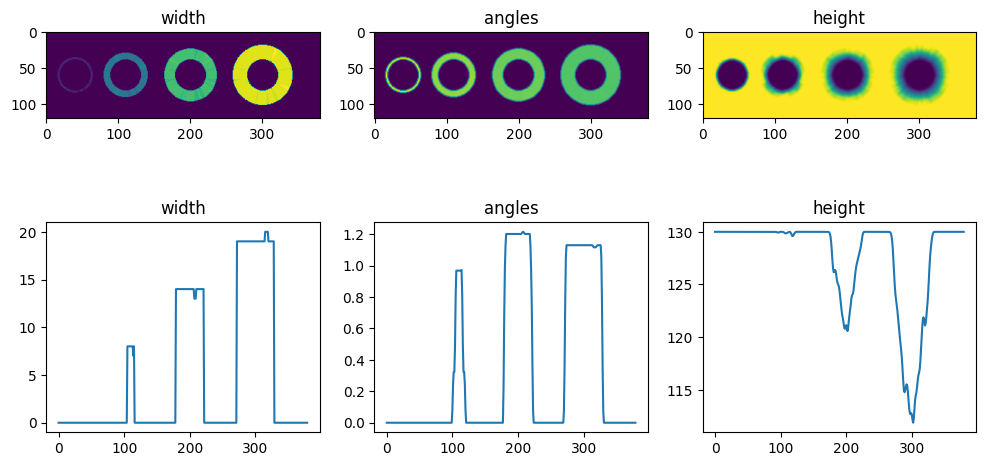

In [265]:
y = 30

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0,0].imshow(width_img)
ax[0,0].set_title(f'width')


ax[0,1].imshow(angles_img)
ax[0,1].set_title(f'angles')

ax[0,2].imshow(height_img)
ax[0,2].set_title(f'height')

ax[1,0].plot(width_img[y, :])
ax[1,0].set_title(f'width')


ax[1,1].plot(angles_img[y, :])
ax[1,1].set_title(f'angles')

ax[1,2].plot(height_img[y, :])
ax[1,2].set_title(f'height')

In [16]:
cv2.imwrite(f'./data/out/color_map.png', height_img.astype(np.uint8))
cv2.imwrite(f'./data/out/angles_map.png', (angles_img*10).astype(np.uint8))


True

In [20]:
print(np.unique(angles_img[:, 80:150]))
print(np.unique(width_img[:, 80:150]))
print(np.unique(height_img[:, 80:150]))



[0.        1.4177176 1.4345037 1.4513674]
[0. 7. 8. 9.]
[ 90.        90.01465   90.02604   90.0293    90.03348   90.03906
  90.043945  90.07324   90.13021   90.131836  90.146484  90.150665
  90.16113   90.16741   90.19531   90.21973   90.27832   90.30762
  90.32389   90.339005  90.34319   90.34877   90.35365   90.37877
  90.390625  90.39551   90.424805  90.4541    90.46875   90.47293
  90.4834    90.50014   90.50642   90.54199   90.56711   90.57129
  90.57849   90.58594   90.598495  90.600586  90.60686   90.625
  90.64035   90.65918   90.66965   90.67383   90.686386  90.71777
  90.74707   90.75846   90.76381   90.77637   90.82031   90.86426
  90.86635   90.87891   90.893555  90.91145   90.92076   90.9375
  90.981445  91.01074   91.04213   91.086075  91.15095   91.15723
  91.186516  91.20117   91.26953   91.2793    91.29324   91.29534
  91.33301   91.33719   91.34766   91.36719   91.37416   91.37695
  91.52344   91.54227   91.58203   91.61133   91.62598   91.71874
  91.75781   91.81641 

In [295]:
# from scipy.spatial.distance import cdist

# distances = cdist(ext[0], int[0])
# nearest_internal_indices = np.argmin(distances, axis=1)
# nearest_internal_indices

# fig, ax = plt.subplots(1,1,figsize=(10, 10))
# cp = np.zeros_like(img_square)
# ax.imshow(cp)

# for i in range(len(ext[0])-1):
#     print(ext[i], int[nearest_internal_indices[i]])


### Разные формулы сигнала

#### Формула №1

mean back 73.8357
mean hole 141.96643
mean bord 31.760317
MIN bord 40.005302
mean color bord:  115.60267
MAX value:  215.6724
MIN value:  130.0067


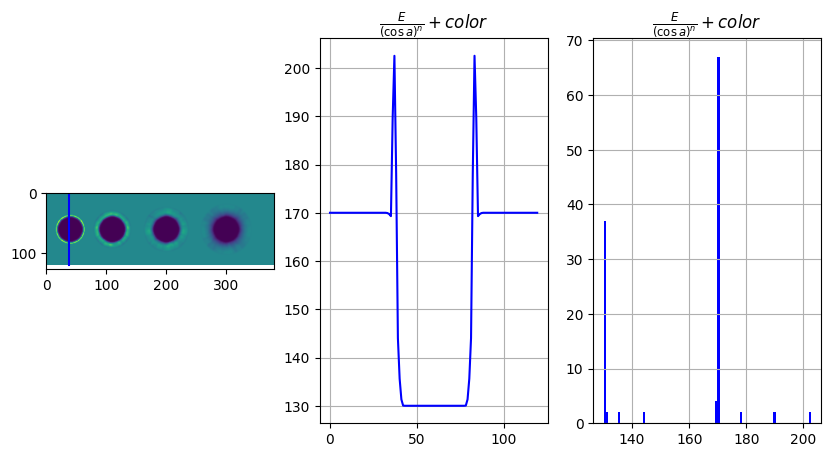

In [311]:
def formula_first(img, angles, color_map, E):
    signal = np.zeros_like(img, dtype=np.float32)

    alpha_bord = angles[img == 128]
    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    print('mean back', np.mean(E / np.abs(np.cos(alpha_back + 1))**(0.87)))
    print('mean hole', np.mean(E / np.abs(np.cos(alpha_hole + 1))**(1.1)))
    print('mean bord', np.mean((E / np.abs(np.cos(alpha_bord)))**(0.87)))
    print('MIN bord', (E / np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)).min())
    print('mean color bord: ', np.mean(color_map[img==128]))

    # signal[crop == 0] =  E / np.cos(alpha_back + 1)**(0.87) + 100
    signal[img == 0] =  (E / (np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87))) + color_map[img==0]

    # signal[crop == 128] = E / np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord))**(0.87) + 120
    # signal[crop == 128] = E / np.abs(np.cos(np.radians(90) - alpha_bord))**(0.87) + color_map[crop==128]
    signal[img == 128] = (E / (np.abs(np.cos(np.radians(90) - (np.radians(180 - 90) - alpha_bord)))**(0.87))) + color_map[img==128]


    # signal[crop == 255] = E / np.cos(alpha_hole + 1)**(1.1) + 60
    signal[img == 255] = (E / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1))) + color_map[img==255]

    signal = np.clip(signal, 0, 255)
    cv2.imwrite(f'./data/out/signal3_E{E}.png', signal.astype(np.uint8))


    return signal

signal_first = formula_first(circle2, new_angles, height_img, E=40)


fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_first)
ax[0].plot([38, 38], [0, signal_first.shape[0]], color='blue')

ax[1].plot(signal_first[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$\frac{E}{(\cos a)^n} + color$')


ax[2].hist(signal_first[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$\frac{E}{(\cos a)^n} + color$')


print('MAX value: ', signal_first.ravel().max())
print('MIN value: ', signal_first.ravel().min())


Text(0.5, 1.0, '$\\frac{E}{(\\cos a)^n} + color$')

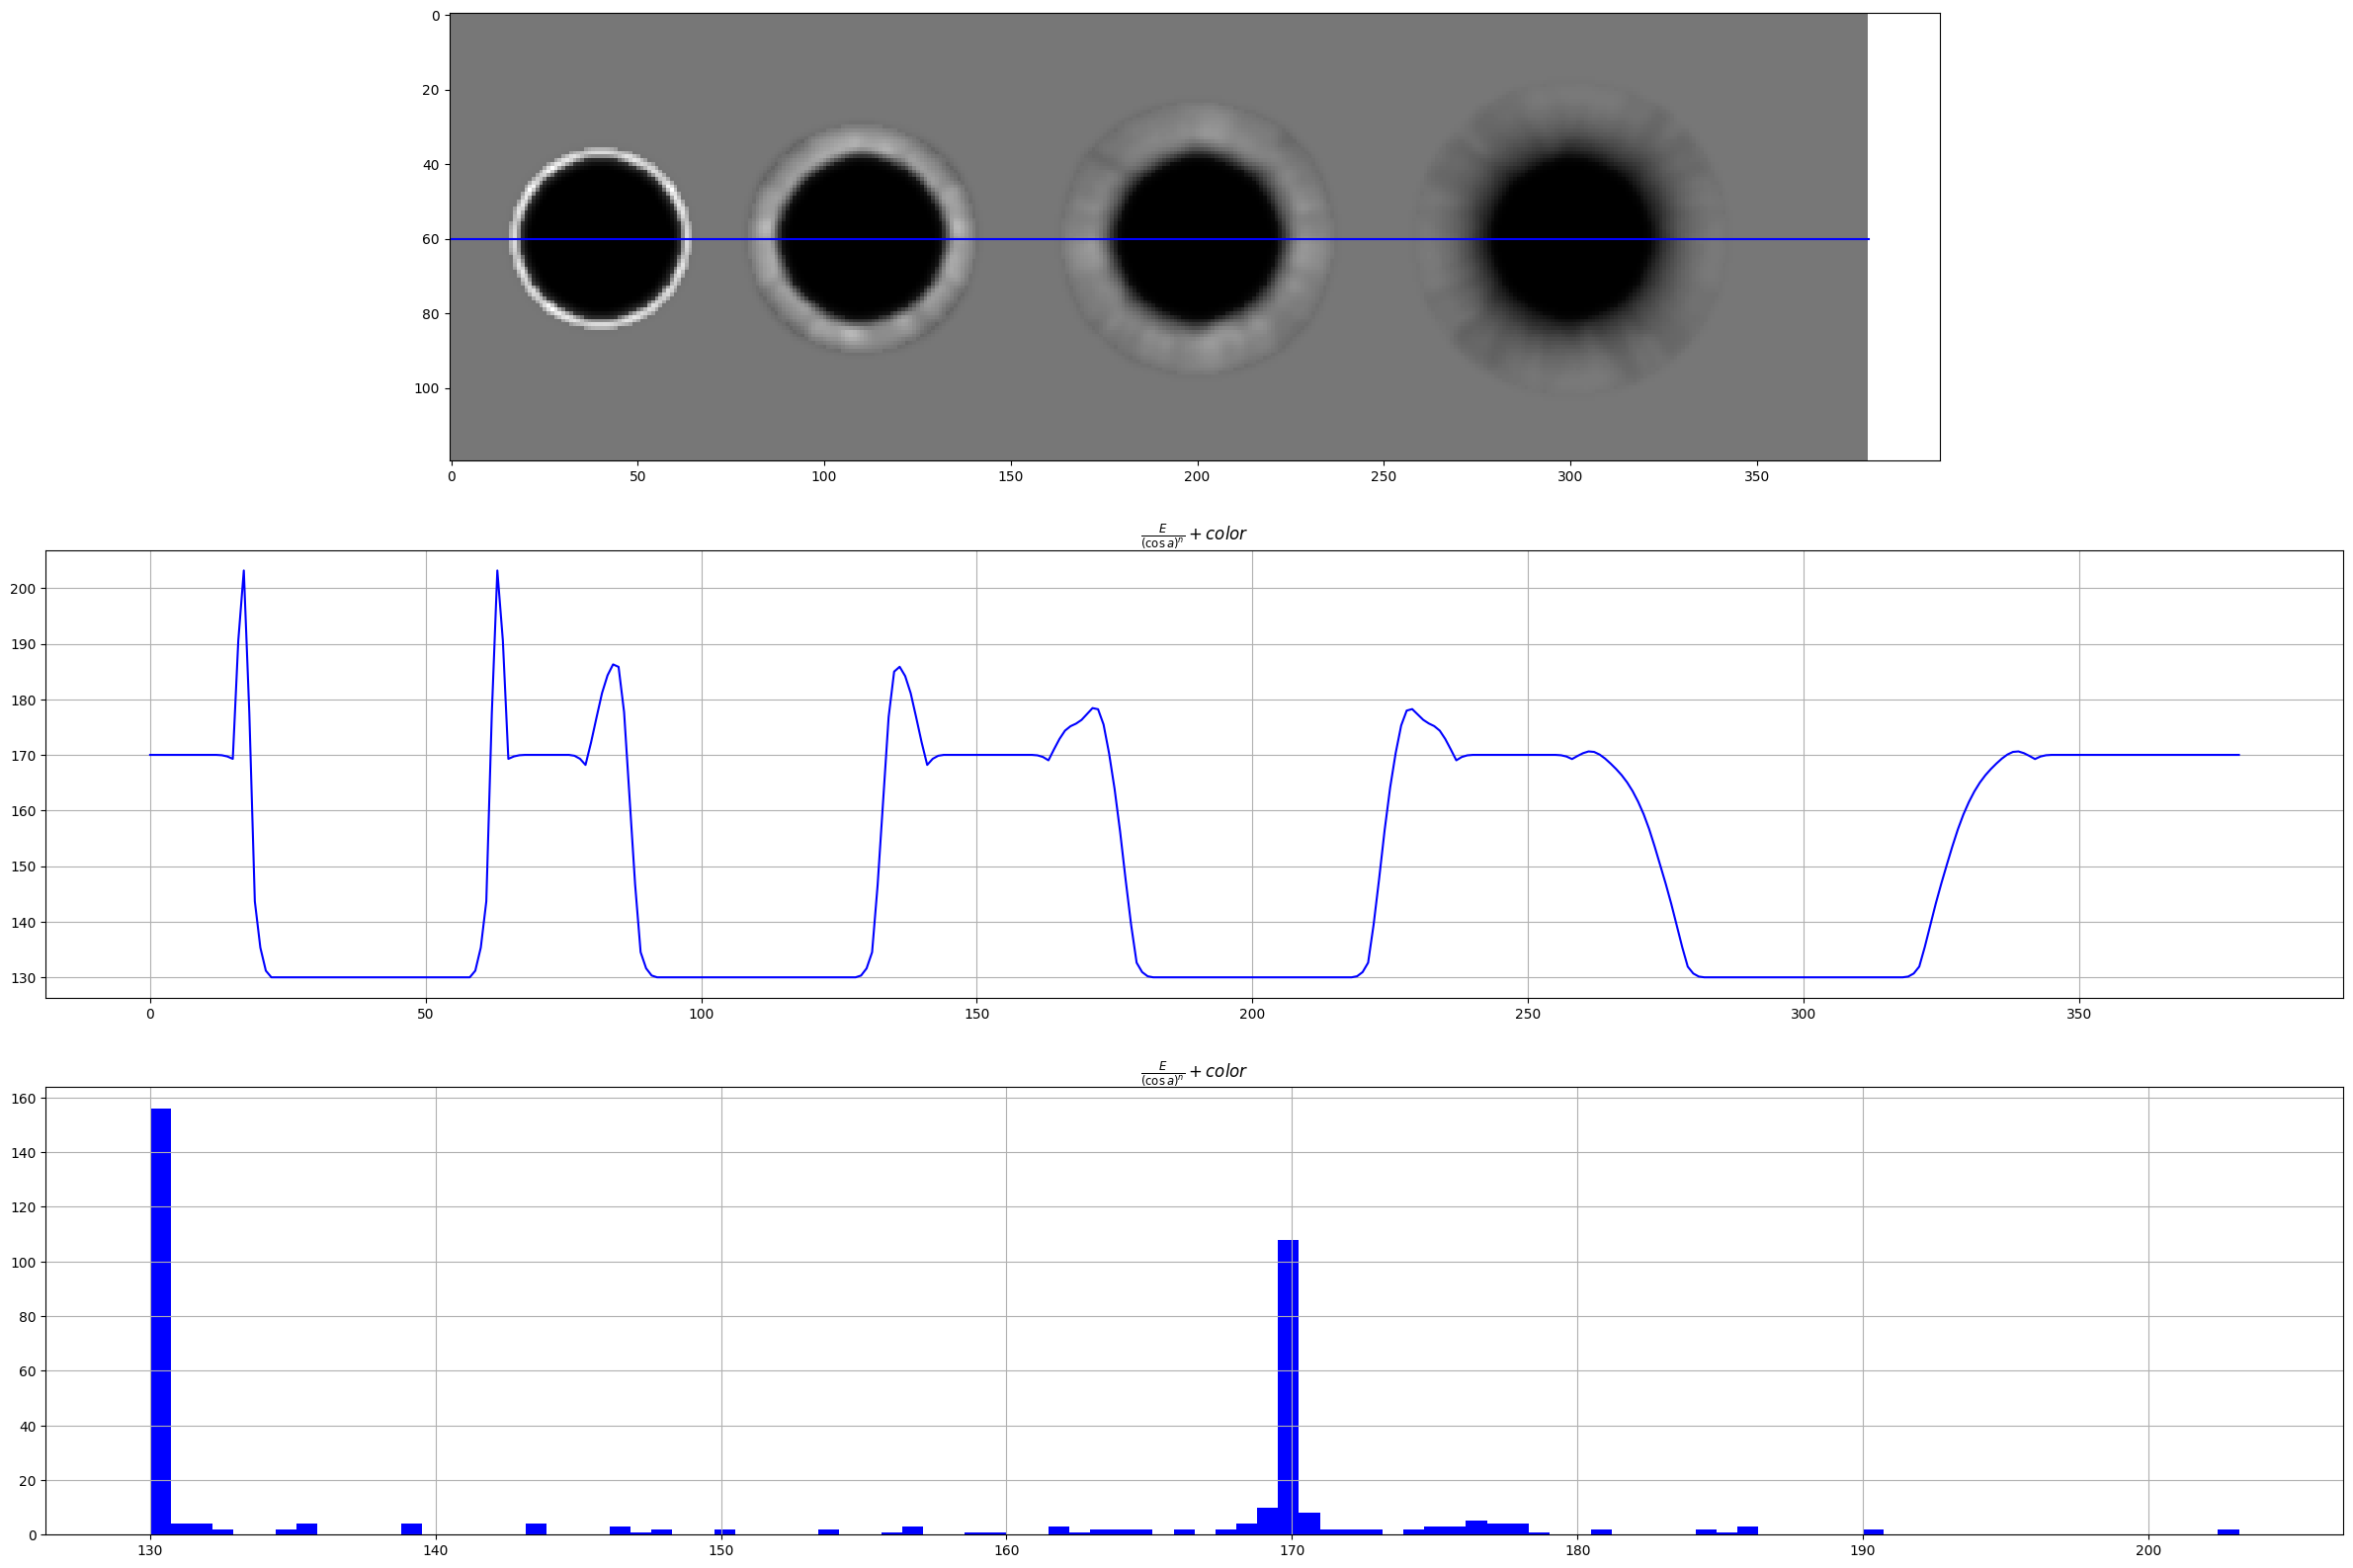

In [315]:
fig, ax = plt.subplots(3, 1, figsize=(30, 20))
ax[0].imshow(signal_first, cmap='gray')
# ax[0].plot([38, 38], [0, signal_first.shape[0]], color='blue')
ax[0].plot([0, signal_first.shape[1]], [60, 60], color='blue')


ax[1].plot(signal_first[60, :], color='blue')
ax[1].grid()
ax[1].set_title(r'$\frac{E}{(\cos a)^n} + color$')


ax[2].hist(signal_first[60, :], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$\frac{E}{(\cos a)^n} + color$')

In [159]:
mask = circle2 == 128
height = height_img.copy()
height[mask] = 120

#### Формула №2

MAX value:  255.0
MIN value:  90.0015


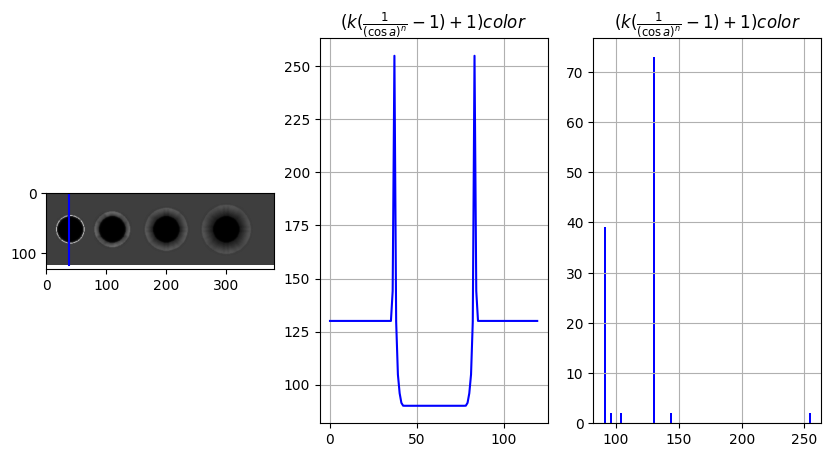

In [244]:
def formula_second(img, angles, color_map, k):
    signal = np.zeros_like(img, dtype=np.float32)


    alpha_bord = angles[img == 128]

    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    # k = k
    signal[img == 0] = (k*(1/(np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87)) - 1) + 1) * color_map[img==0]

    signal[img == 128] = (k * (1/(np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)) - 1) + 1) *color_map[img==128]


    signal[img == 255] = (k * (1 / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1)) - 1) + 1) * color_map[img==255]

    signal = np.clip(signal, 0, 255)
    cv2.imwrite(f'./data/out/signal1_var2_img_circles3_k{k}.png', signal.astype(np.uint8))

    return signal

signal_second = formula_second(circle2, angles_img, height_img, 0.1)
  

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_second, cmap='gray')
ax[0].plot([38, 38], [0,signal_second.shape[0]], color='blue')

ax[1].plot(signal_second[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

ax[2].hist(signal_second[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

print('MAX value: ', signal_second.ravel().max())
print('MIN value: ', signal_second.ravel().min())



#### Формула №3

MAX value:  255.0
MIN value:  99.01659


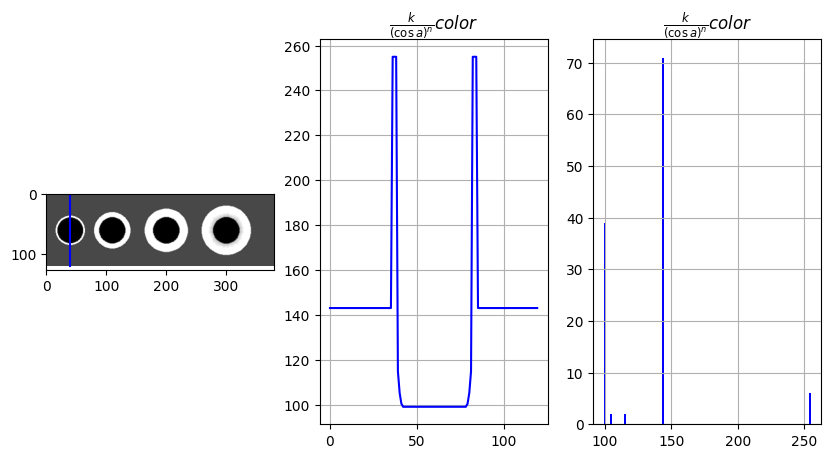

In [240]:
def formula_third(img, angles, color_map):
    signal = np.zeros_like(img, dtype=np.float32)

    alpha_bord = angles[img == 128]


    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    k = 1.1
    # signal[crop == 0] = (1.3 / (np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87))) *color_map[crop==0]
    signal[img == 0] = (k / (np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87))) *color_map[img==0]


    # signal[crop == 128] = (1.5 / (np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87))) *color_map[crop==128]
    signal[img == 128] = (k / (np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87))) *color_map[img==128]


    # signal[crop == 255] = (1.2 / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1))) * color_map[crop==255]
    signal[img == 255] = (k / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1))) * color_map[img==255]


    signal = np.clip(signal, 0, 255)
    cv2.imwrite(f'./data/out/signal1_var3_img_circles3_k{k}.png', signal.astype(np.uint8))


    return signal


signal_third = formula_third(circle2, angles_img, height_img)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_third, cmap='gray')
ax[0].plot([40, 40], [0,signal_third.shape[0]], color='blue')

ax[1].plot(signal_third[:, 40], color='blue')
ax[1].grid()
ax[1].set_title(r'$\frac{k}{(\cos a)^n}color$')

ax[2].hist(signal_third[:, 40], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$\frac{k}{(\cos a)^n}color$')


print('MAX value: ', signal_third.ravel().max())
print('MIN value: ', signal_third.ravel().min())

def formula_third()

проблемы:
- не всегда берет нужную точку ? потому что расстояние не всегда именно минимальное
- есть пропущенные пиксели в границе

In [66]:
cont_int = np.array([list(reversed(cont_in)) for cont_in in cont_int])
cont_int

array([[ 61,  63],
       [ 62,  63],
       [ 63,  63],
       [ 64,  63],
       [ 65,  63],
       [ 66,  63],
       [ 67,  63],
       [ 68,  63],
       [ 69,  63],
       [ 58,  64],
       [ 59,  64],
       [ 60,  64],
       [ 70,  64],
       [ 71,  64],
       [ 72,  64],
       [ 56,  65],
       [ 57,  65],
       [ 73,  65],
       [ 74,  65],
       [ 54,  66],
       [ 55,  66],
       [ 75,  66],
       [ 76,  66],
       [ 77,  66],
       [ 53,  67],
       [ 78,  67],
       [ 51,  68],
       [ 52,  68],
       [ 78,  68],
       [ 79,  68],
       [ 50,  69],
       [ 80,  69],
       [ 49,  70],
       [ 81,  70],
       [ 48,  71],
       [ 82,  71],
       [ 48,  72],
       [ 82,  72],
       [ 47,  73],
       [ 83,  73],
       [ 46,  74],
       [ 84,  74],
       [ 46,  75],
       [ 84,  75],
       [ 45,  76],
       [ 85,  76],
       [ 45,  77],
       [ 85,  77],
       [ 44,  78],
       [ 86,  78],
       [ 44,  79],
       [ 86,  79],
       [ 44,

In [64]:
cont_int.swapaxes(0,1).swapaxes(0, 1)

array([[ 63,  61],
       [ 63,  62],
       [ 63,  63],
       [ 63,  64],
       [ 63,  65],
       [ 63,  66],
       [ 63,  67],
       [ 63,  68],
       [ 63,  69],
       [ 64,  58],
       [ 64,  59],
       [ 64,  60],
       [ 64,  70],
       [ 64,  71],
       [ 64,  72],
       [ 65,  56],
       [ 65,  57],
       [ 65,  73],
       [ 65,  74],
       [ 66,  54],
       [ 66,  55],
       [ 66,  75],
       [ 66,  76],
       [ 66,  77],
       [ 67,  53],
       [ 67,  78],
       [ 68,  51],
       [ 68,  52],
       [ 68,  78],
       [ 68,  79],
       [ 69,  50],
       [ 69,  80],
       [ 70,  49],
       [ 70,  81],
       [ 71,  48],
       [ 71,  82],
       [ 72,  48],
       [ 72,  82],
       [ 73,  47],
       [ 73,  83],
       [ 74,  46],
       [ 74,  84],
       [ 75,  46],
       [ 75,  84],
       [ 76,  45],
       [ 76,  85],
       [ 77,  45],
       [ 77,  85],
       [ 78,  44],
       [ 78,  86],
       [ 79,  44],
       [ 79,  86],
       [ 80,

In [55]:
np.transpose(cont_int[:],(1,0))

array([[ 63,  63,  63,  63,  63,  63,  63,  63,  63,  64,  64,  64,  64,
         64,  64,  65,  65,  65,  65,  66,  66,  66,  66,  66,  67,  67,
         68,  68,  68,  68,  69,  69,  70,  70,  71,  71,  72,  72,  73,
         73,  74,  74,  75,  75,  76,  76,  77,  77,  78,  78,  79,  79,
         80,  80,  81,  81,  82,  82,  83,  83,  84,  84,  85,  85,  86,
         86,  87,  87,  88,  88,  89,  89,  90,  90,  91,  91,  92,  92,
         93,  93,  94,  94,  95,  95,  96,  96,  97,  97,  98,  98,  98,
         98,  99,  99, 100, 100, 101, 101, 102, 102, 102, 102, 103, 103,
        104, 104, 104, 104, 104, 105, 105, 105, 105, 106, 106, 106, 106,
        106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  58,  59,  60,  70,
         71,  72,  56,  57,  73,  74,  54,  55,  75,  76,  77,  53,  78,
         51,  52,  78,  79,  50,  80,  49,  81,  48,  82,  48,  82,  47,
         83,  46,  84,  46,  84,  45,  85,  45,  85,  44,  8

In [51]:
cont_int

array([[ 63,  61],
       [ 63,  62],
       [ 63,  63],
       [ 63,  64],
       [ 63,  65],
       [ 63,  66],
       [ 63,  67],
       [ 63,  68],
       [ 63,  69],
       [ 64,  58],
       [ 64,  59],
       [ 64,  60],
       [ 64,  70],
       [ 64,  71],
       [ 64,  72],
       [ 65,  56],
       [ 65,  57],
       [ 65,  73],
       [ 65,  74],
       [ 66,  54],
       [ 66,  55],
       [ 66,  75],
       [ 66,  76],
       [ 66,  77],
       [ 67,  53],
       [ 67,  78],
       [ 68,  51],
       [ 68,  52],
       [ 68,  78],
       [ 68,  79],
       [ 69,  50],
       [ 69,  80],
       [ 70,  49],
       [ 70,  81],
       [ 71,  48],
       [ 71,  82],
       [ 72,  48],
       [ 72,  82],
       [ 73,  47],
       [ 73,  83],
       [ 74,  46],
       [ 74,  84],
       [ 75,  46],
       [ 75,  84],
       [ 76,  45],
       [ 76,  85],
       [ 77,  45],
       [ 77,  85],
       [ 78,  44],
       [ 78,  86],
       [ 79,  44],
       [ 79,  86],
       [ 80,

In [50]:
# cont_int
np.swapaxes(cont_int[:],0,1)

array([[ 63,  63,  63,  63,  63,  63,  63,  63,  63,  64,  64,  64,  64,
         64,  64,  65,  65,  65,  65,  66,  66,  66,  66,  66,  67,  67,
         68,  68,  68,  68,  69,  69,  70,  70,  71,  71,  72,  72,  73,
         73,  74,  74,  75,  75,  76,  76,  77,  77,  78,  78,  79,  79,
         80,  80,  81,  81,  82,  82,  83,  83,  84,  84,  85,  85,  86,
         86,  87,  87,  88,  88,  89,  89,  90,  90,  91,  91,  92,  92,
         93,  93,  94,  94,  95,  95,  96,  96,  97,  97,  98,  98,  98,
         98,  99,  99, 100, 100, 101, 101, 102, 102, 102, 102, 103, 103,
        104, 104, 104, 104, 104, 105, 105, 105, 105, 106, 106, 106, 106,
        106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  58,  59,  60,  70,
         71,  72,  56,  57,  73,  74,  54,  55,  75,  76,  77,  53,  78,
         51,  52,  78,  79,  50,  80,  49,  81,  48,  82,  48,  82,  47,
         83,  46,  84,  46,  84,  45,  85,  45,  85,  44,  8

In [37]:
np.transpose(cont_int)

array([[ 63,  63,  63,  63,  63,  63,  63,  63,  63,  64,  64,  64,  64,
         64,  64,  65,  65,  65,  65,  66,  66,  66,  66,  66,  67,  67,
         68,  68,  68,  68,  69,  69,  70,  70,  71,  71,  72,  72,  73,
         73,  74,  74,  75,  75,  76,  76,  77,  77,  78,  78,  79,  79,
         80,  80,  81,  81,  82,  82,  83,  83,  84,  84,  85,  85,  86,
         86,  87,  87,  88,  88,  89,  89,  90,  90,  91,  91,  92,  92,
         93,  93,  94,  94,  95,  95,  96,  96,  97,  97,  98,  98,  98,
         98,  99,  99, 100, 100, 101, 101, 102, 102, 102, 102, 103, 103,
        104, 104, 104, 104, 104, 105, 105, 105, 105, 106, 106, 106, 106,
        106, 106, 107, 107, 107, 107, 107, 107, 107, 107, 107],
       [ 61,  62,  63,  64,  65,  66,  67,  68,  69,  58,  59,  60,  70,
         71,  72,  56,  57,  73,  74,  54,  55,  75,  76,  77,  53,  78,
         51,  52,  78,  79,  50,  80,  49,  81,  48,  82,  48,  82,  47,
         83,  46,  84,  46,  84,  45,  85,  45,  85,  44,  8

In [112]:
len(cont_circle21)

4

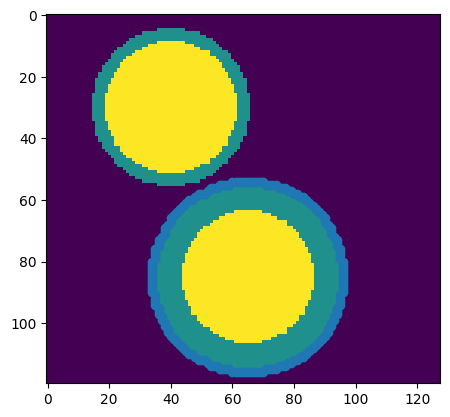

In [150]:
mask_cont = np.zeros_like(circle2)
mask_cont = cv2.drawContours(mask_cont, [cont_circle21[0]], 0, 1, 0)
mask = cv2.inRange(circle2, 128, 128)
intersection = mask*mask_cont
nonzero = np.argwhere(intersection > 0)
plt.imshow(circle2)
plt.scatter(nonzero[:,1], nonzero[:,0])

In [148]:
mask_cont.shape

(120, 128)

In [149]:
mask.shape

(120, 128)

[  0. 255.]


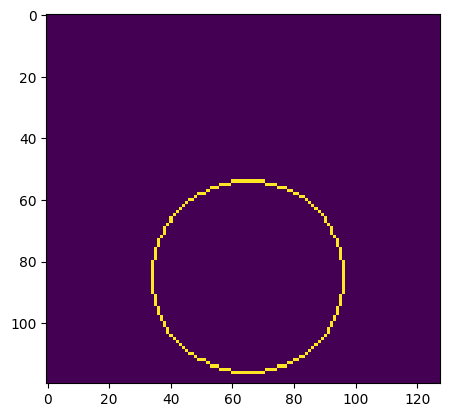

In [107]:
res = mask_cont * mask
print(np.unique(res))
plt.imshow(res == 255)

### Получение карты углов

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

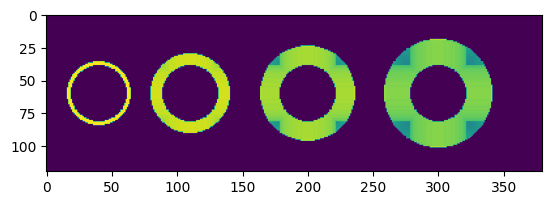

In [8]:
def get_edges_angles(img, edges_width):
    return np.arctan(700 / (edges_width[img == 128] * 12))

angles_edges_img_circles = np.zeros_like(img_circles, dtype=np.float32)
angles_edges_img_circles[img_circles==128] = get_edges_angles(img_circles, img_circles_edges_width)

plt.imshow(angles_edges_img_circles)
plt.plot

Text(0.5, 1.0, 'график карты углов в радианах, y=50')

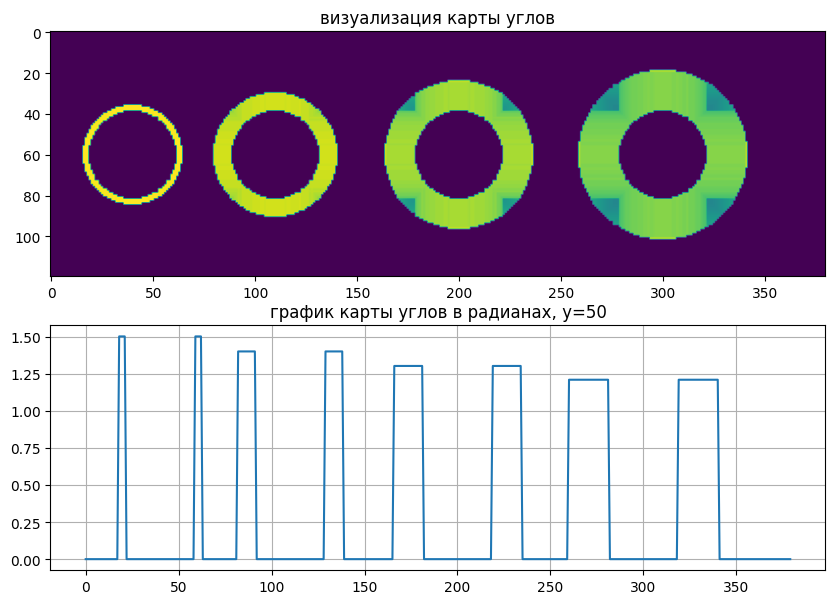

In [55]:
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
y = 50
ax[0].imshow(angles_edges_img_circles)
ax[0].set_title('визуализация карты углов')
# ax[1].plot(np.arange(0, len(angles_edges_img_circles)), angles_edges_img_circles[:,45])
ax[1].plot(np.arange(0, angles_edges_img_circles.shape[1]), angles_edges_img_circles[y,:])

ax[1].grid()
ax[1].set_title(f'график карты углов в радианах, y={y}')

### Получение карты цветов

In [10]:
color_back = 120
color_hole = 90
color_edge = (color_back + color_hole)//2

[  0 255]


Text(0.5, 1.0, 'График карты углов, y=35')

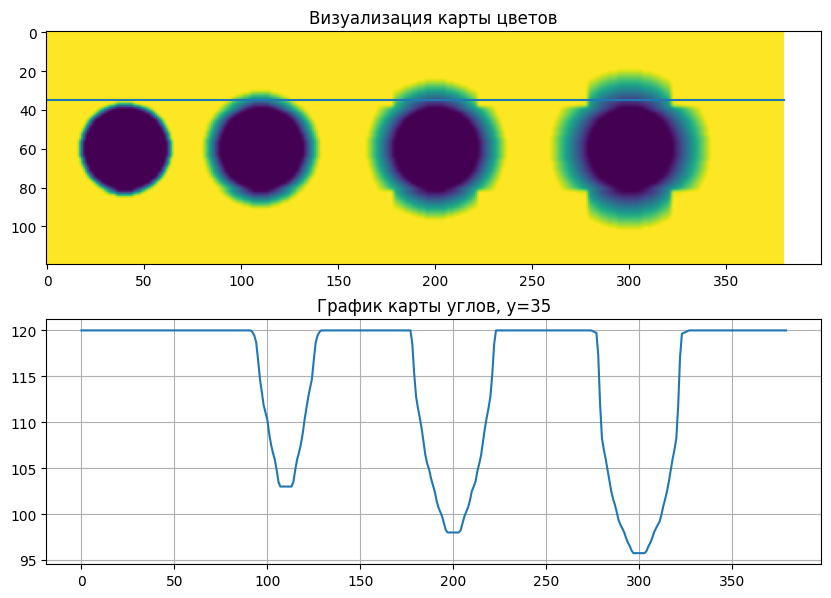

In [11]:
def get_color_map(img, color_back, color_hole):
    bord_mask = cv2.inRange(img, 128, 128)
    bord_mask[bord_mask == 255] = 128

    hole_mask = cv2.inRange(img, 255,255)
    print(np.unique(hole_mask))
    color_final = np.zeros_like(img)
    rows, cols = img.shape
    color_final[img == 0] = color_back # у фона цвет 100
    color_final[img == 255] = color_hole # у дна цвет 90

    for col in range(0, cols):
        col_mask_bord = bord_mask[:,col]
        col_mask_hole = hole_mask[:,col]
        start_ind_bord = np.where(np.diff(col_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(col_mask_hole == 255))[0] + 1
        gray_segments = []

        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)

        for segm in work_segments:
            delta = segm[1] - segm[0]
            for i in (np.arange(segm[0], segm[1])):
                if img[segm[1]+1, col] < img[segm[0]-1, col]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[i, col] = k_val

        if (len(other_segments) != 0) and (len(gray_segments) != 0):
            # print('no hole here')
            # print(gray_segments, other_segments)
            for segment in other_segments:
                delta = segment[1] - segment[0]
                segm1 = (segment[0], segment[0] + delta//2)
                segm2 = (segment[0] + delta//2, segment[1])

                for segm in [segm1, segm2]:
                    # print(segm)
                    for i in (np.arange(segm[0], segm[1])):
                        if img[segm[1]+1, col] > img[segm[0]-1, col]:
                            # print('>')
                            k = delta//2 - (segm[1] - i)
                        else:
                            k = delta//2 - (np.abs(segm[0] - i))
                        k_val = color_back - k * (color_back - color_edge) // delta//2
                        # print(k_val)
                        color_final[i, col] = k_val       

    for row in range(0, rows):
        row_mask_bord = bord_mask[row,:]
        row_mask_hole = hole_mask[row,:]

        start_ind_bord = np.where(np.diff(row_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(row_mask_hole == 255))[0] + 1
        gray_segments = []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)

        for segm in work_segments:
            delta = segm[1] - segm[0]
            for i in (np.arange(segm[0], segm[1]+1)):
                
                if img[row, segm[1]+1] < img[row, segm[0]-1]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[row, i] = k_val
    # mask = img==128
    color_final = cv2.GaussianBlur(color_final, (3, 3), 0)
    return color_final

color_map = get_color_map(img_circles, color_back, color_hole)
fig, ax = plt.subplots(2, 1, figsize=(10, 7))
y = 35
x = 170
ax[0].imshow(color_map)
ax[0].plot([0, color_map.shape[1]], [y, y])
ax[0].set_title('Визуализация карты цветов')

ax[1].plot(np.arange(0, color_map.shape[1]), color_map[y,:])
# ax[1].plot(np.arange(0, color_map_new.shape[0]), color_map_new[:,x])


ax[1].grid()
ax[1].set_title(f'График карты углов, y={y}')


### Аппроксимация карты углов

In [12]:
def parabola(x, a, b, c):
    return a*x**2 + b*x + c

8
8
7
7
6
6
5
4
5
5
4
4
4
4
4
4
4
4
4
4
3
3
4
4
3
3
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
3
3
4
4
3
3
3
3
4
4
4
4
4
4
4
4
5
5
5
4
6
6
7
7
8
8
18
18
15
15
14
14
13
12
13
13
11
11
11
11
11
11
11
11
11
11
10
10
10
10
10
10
10
10
9
9
9
9
10
10
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
9
9
9
9
10
10
10
10
10
10
10
10
9
9
11
11
11
11
11
11
11
11
13
13
13
12
14
14
15
15
18
18
26
26
23
23
22
22
20
19
20
20
18
18
18
18
17
17
17
17
17
17
16
16
16
16
16
16
16
16
15
15
15
15
16
16
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
15
15
15
15
16
16
16
16
16
16
16
16
16
16
17
17
17
17
18
18
18
18
20
20
20
19
22
22
23
23
26
26
31
31
29
29
27
27
26
25
25
25
24
24
23
23
23
23
23
23
22
22
22
22
22
22
21
21
21
21
20
20
21
21
21
21
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
20
20
21
21
21
21
22
22
22
22
21
21
23
23
23
23
23
23
24
24
25
25
26
25
27
27
29
29
31
31


Text(0.5, 1.0, 'График карты углов, y=50')

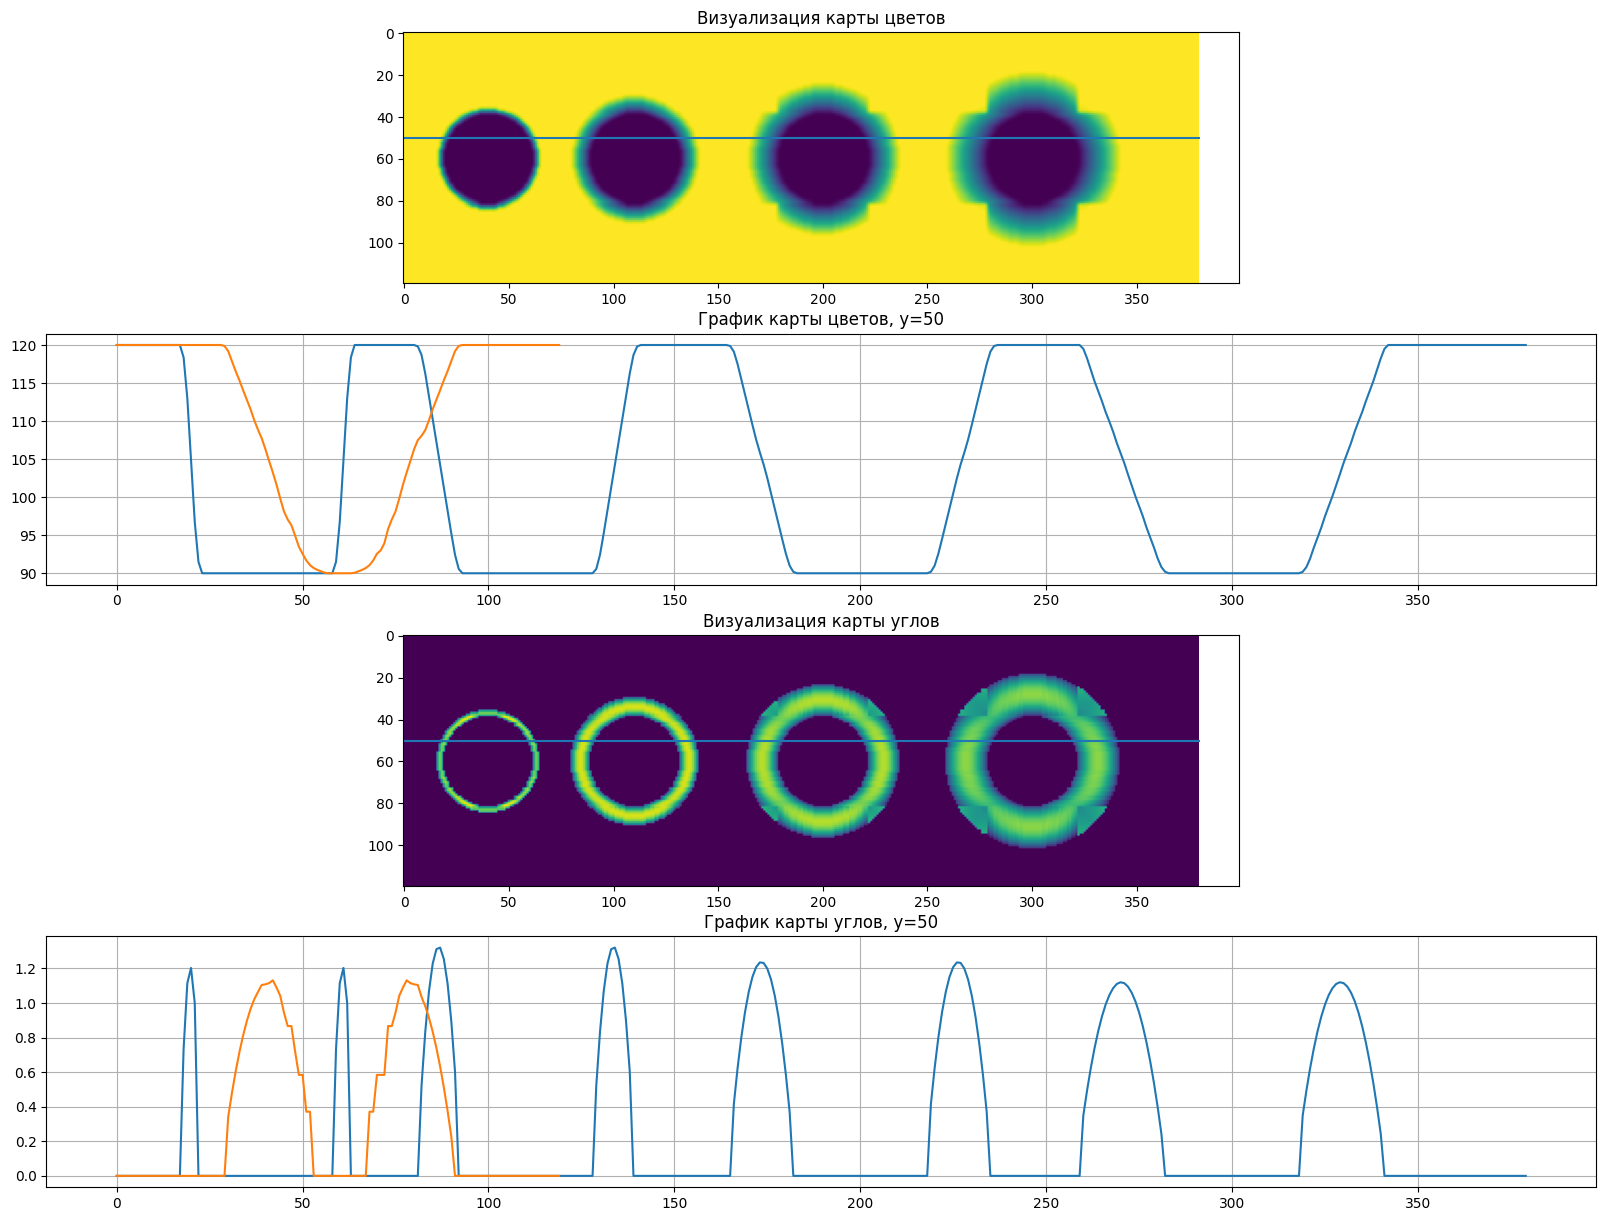

In [88]:
def get_colors_angles(img, angles_edges, color_back, color_hole):
    bord_mask = cv2.inRange(img, 128, 128)
    bord_mask[bord_mask == 255] = 128

    hole_mask = cv2.inRange(img, 255,255)
    color_final = np.zeros_like(img)
    angles_final = angles_edges.copy()
    # angles_final = np.zeros_like(img)
    rows, cols = img.shape
    color_final[img == 0] = color_back # у фона цвет 100
    color_final[img == 255] = color_hole # у дна цвет 90

    for col in range(0, cols):
        col_mask_bord = bord_mask[:,col]
        col_mask_hole = hole_mask[:,col]
        start_ind_bord = np.where(np.diff(col_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(col_mask_hole == 255))[0] + 1
        gray_segments = []

        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)
            delta = segm[1] - segm[0]
            # angles_final[segm[0]:segm[1], col] = angles_edges[segm[0]:segm[1], col]

        for segm in work_segments:
            delta = segm[1] - segm[0]
            print(delta)
            for i in (np.arange(segm[0], segm[1])):
                if img[segm[1]+1, col] < img[segm[0]-1, col]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[i, col] = k_val

            if delta >= 3:
                ind_mean = segm[0] + delta // 2
                y_mean_lagrange = angles_edges[ind_mean, col]

                y_0 = angles_edges[segm[0], col]/2
                y_n = angles_edges[segm[1], col]/2
                
                x_1 = segm[0] - 1
                x_2 = segm[1] + 1

                y_1 = angles_edges[x_1, col]
                y_2 = angles_edges[x_2, col]

                # if delta < 4:
                #     coef = 0
                # else:
                coef = delta/10
                y_mean_lagrange = y_mean_lagrange - coef*0.05
                y_0_ = y_0 - coef*0.02
                y_n_ = y_n - coef*0.02

                coefs = curve_fit(parabola, [x_1, segm[0], ind_mean, segm[1], x_2], [y_1, y_0_, y_mean_lagrange, y_n_, y_2])
                a,b,c = coefs[0]
                
                x_for_plot = np.arange(segm[0], segm[1])
                y_parabola = parabola(x_for_plot, a, b, c)
                angles_final[segm[0]:segm[1], col] = y_parabola
            # else:
            #     angles_final[segm[0]:segm[1], col] = angles_edges[segm[0]:segm[1], col]


        if (len(other_segments) != 0) and (len(gray_segments) != 0):
            for segment in other_segments:
                delta = segment[1] - segment[0]
                segm1 = (segment[0], segment[0] + delta//2)
                segm2 = (segment[0] + delta//2, segment[1])

                for segm in [segm1, segm2]:
                    for i in (np.arange(segm[0], segm[1])):
                        if img[segm[1]+1, col] > img[segm[0]-1, col]:
                            k = delta//2 - (segm[1] - i)
                        else:
                            k = delta//2 - (np.abs(segm[0] - i))
                        k_val = color_back - k * (color_back - color_edge) // delta//2
                        color_final[i, col] = k_val       

    for row in range(0, rows):
        row_mask_bord = bord_mask[row,:]
        row_mask_hole = hole_mask[row,:]

        start_ind_bord = np.where(np.diff(row_mask_bord == 128))[0] + 1
        start_ind_hole = np.where(np.diff(row_mask_hole == 255))[0] + 1
        gray_segments = []
        for i in range(0, len(start_ind_bord), 2):
            gray_segments.append((start_ind_bord[i], start_ind_bord[i+1]))
        
        work_segments = []
        other_segments = []
        for segm in gray_segments:
            for i in segm:
                if i in start_ind_hole:
                    work_segments.append(segm)
            if segm not in work_segments:
                other_segments.append(segm)
            delta = segm[1] - segm[0]
            # angles_final[row, segm[0]:segm[1]] = angles_edges[row, segm[0]:segm[1]]

        for segm in work_segments:
            delta = segm[1] - segm[0]
            for i in (np.arange(segm[0], segm[1]+1)):
                
                if img[row, segm[1]+1] < img[row, segm[0]-1]:
                    k = delta - (segm[1] - i)
                else:
                    k = delta - (np.abs(segm[0] - i))
                k_val = k * (color_back - color_hole) // delta + color_hole
                color_final[row, i] = k_val

            if delta >= 3:
                ind_mean = segm[0] + delta // 2
                y_mean_lagrange = angles_edges[row, ind_mean]

                y_0 = angles_edges[row, segm[0]]/2
                y_n = angles_edges[row, segm[1]]/2
                
                x_1 = segm[0] - 1
                x_2 = segm[1] + 1

                y_1 = angles_edges[row, x_1]
                y_2 = angles_edges[row, x_2]

                coef = delta/10
                y_mean_lagrange = y_mean_lagrange - coef*0.05
                y_0_ = y_0 - coef*0.02
                y_n_ = y_n - coef*0.02

                coefs = curve_fit(parabola, [x_1, segm[0], ind_mean, segm[1], x_2], [y_1, y_0_, y_mean_lagrange, y_n_, y_2])
                a,b,c = coefs[0]
                
                x_for_plot = np.arange(segm[0], segm[1])
                y_parabola = parabola(x_for_plot, a, b, c)
                angles_final[row, segm[0]:segm[1]] = y_parabola
            # else:
            #     angles_final[row, segm[0]:segm[1]] = angles_edges[row, segm[0]:segm[1]]

    color_final = cv2.GaussianBlur(color_final, (3, 3), 0)
    # angles_final = cv2.GaussianBlur(angles_final, (3, 3), 0)
    return color_final, angles_final

color_map_new, angles_final = get_colors_angles(img_circles, angles_edges_img_circles, color_back, color_hole)
fig, ax = plt.subplots(4, 1, figsize=(20, 15))
y = 50
x = 180
ax[0].imshow(color_map_new)
ax[0].plot([0, color_map_new.shape[1]], [y, y])
ax[0].set_title('Визуализация карты цветов')

ax[1].plot(np.arange(0, color_map_new.shape[1]), color_map_new[y,:])
ax[1].plot(np.arange(0, color_map_new.shape[0]), color_map_new[:,x])
ax[1].grid()
ax[1].set_title(f'График карты цветов, y={y}')

ax[2].imshow(angles_final)
ax[2].plot([0, angles_final.shape[1]], [y, y])
ax[2].set_title('Визуализация карты углов')

ax[3].plot(np.arange(0, angles_final.shape[1]),angles_final[y,:])
ax[3].plot(np.arange(0, angles_final.shape[0]), angles_final[:,x])


ax[3].grid()
ax[3].set_title(f'График карты углов, y={y}')


### Разные формулы сигнала

#### Формула №1

mean back 42.711613
mean hole 49.208435
mean bord 27.958418
MIN bord 25.003313
mean color bord:  106.83742
MAX value:  226.24031
MIN value:  115.00419


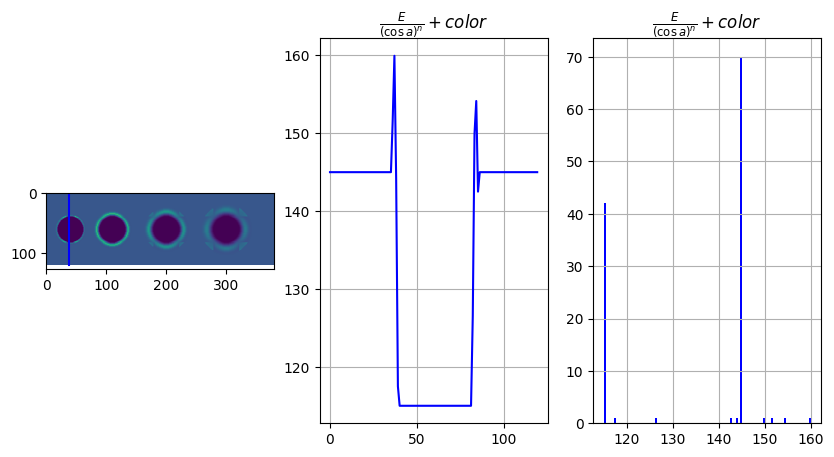

In [89]:
def formula_first(img, angles, color_map, E):
    signal = np.zeros_like(img, dtype=np.float32)

    alpha_bord = angles[img == 128]
    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    print('mean back', np.mean(E / np.abs(np.cos(alpha_back + 1))**(0.87)))
    print('mean hole', np.mean(E / np.abs(np.cos(alpha_hole + 1))**(1.1)))
    print('mean bord', np.mean((E / np.abs(np.cos(alpha_bord)))**(0.87)))
    print('MIN bord', (E / np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)).min())
    print('mean color bord: ', np.mean(color_map[img==128]))

    # signal[crop == 0] =  E / np.cos(alpha_back + 1)**(0.87) + 100
    signal[img == 0] =  (E / (np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87))) + color_map[img==0]

    # signal[crop == 128] = E / np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord))**(0.87) + 120
    # signal[crop == 128] = E / np.abs(np.cos(np.radians(90) - alpha_bord))**(0.87) + color_map[crop==128]
    signal[img == 128] = (E / (np.abs(np.cos(np.radians(90) - (np.radians(180 - 90) - alpha_bord)))**(0.87))) + color_map[img==128]


    # signal[crop == 255] = E / np.cos(alpha_hole + 1)**(1.1) + 60
    signal[img == 255] = (E / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1))) + color_map[img==255]

    signal = np.clip(signal, 0, 255)
    cv2.imwrite(f'./data/out/var1_img_circles3_E{E}.png', signal.astype(np.uint8))


    return signal

signal_first = formula_first(img_circles, angles_img, color_map_new, E=25)


fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_first)
ax[0].plot([38, 38], [0, signal_first.shape[0]], color='blue')

ax[1].plot(signal_first[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$\frac{E}{(\cos a)^n} + color$')


ax[2].hist(signal_first[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$\frac{E}{(\cos a)^n} + color$')


print('MAX value: ', signal_first.ravel().max())
print('MIN value: ', signal_first.ravel().min())


In [265]:
def formula_second(img, angles, color_map):
    signal = np.zeros_like(img, dtype=np.float32)


    alpha_bord = angles[img == 128]

    alpha_bord[alpha_bord==alpha_bord.min()] = np.radians(1)

    alpha_back = angles[img == 0]
    alpha_hole = angles[img == 255]

    k = 0.3
    signal[img == 0] = (k*(1/(np.abs(np.cos(np.radians(alpha_back + 1)))**(0.87)) - 1) + 1) * color_map[img==0]

    signal[img == 128] = (k * (1/(np.abs(np.cos(np.radians(90)-(np.radians(180 - 90) - alpha_bord)))**(0.87)) - 1) + 1) *color_map[img==128]


    signal[img == 255] = (k * (1 / (np.abs(np.cos(np.radians(alpha_hole + 1)))**(1.1)) - 1) + 1) * color_map[img==255]

    signal = np.clip(signal, 0, 255)
    cv2.imwrite(f'./data/out/var2_img_circles3_k{k}.png', signal.astype(np.uint8))

    return signal

signal_second = formula_second(circle2, angles_img, height_img)
  

fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(signal_second, cmap='gray')
ax[0].plot([38, 38], [0,signal_second.shape[0]], color='blue')

ax[1].plot(signal_second[:, 38], color='blue')
ax[1].grid()
ax[1].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

ax[2].hist(signal_second[:, 38], color='blue', bins=100)
ax[2].grid()
ax[2].set_title(r'$(k(\frac{1}{(\cos a)^n} - 1) + 1)color$')

print('MAX value: ', signal_second.ravel().max())
print('MIN value: ', signal_second.ravel().min())



NameError: name 'angles_final' is not defined